# Install pkgs

**Note:** This is training notebook only. Inference ain't included in . 
Anybody who wants to use this notebook for inference purposes is most welcome.

In [1]:
import os
import shutil
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from torch.utils.tensorboard import SummaryWriter
import zarr, copick
from tqdm import tqdm
import napari
import mlflow
import mlflow.pytorch
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import gc
import concurrent.futures
import optuna, optunahub
from optuna.visualization import plot_slice, plot_param_importances
import json
import copy
import random

gc.enable()

In [2]:
torch._dynamo.config.cache_size_limit = 64
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

In [3]:
path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/'
output_path = path + 'output/'

In [4]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 2,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 3,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 4,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 5,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],

    "overlay_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = path + "output/copick.config"
output_overlay = path + "output/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = path + 'train/overlay'
destination_dir = path + 'output/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/apo-ferritin.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_apo-ferritin.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-amylase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-amylase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-galactosidase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-galactosidase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/ribosome.json to /media

# Prepare the dataset
## 1. Get copick root

In [5]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
#tomo_type = "denoised"

## 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [6]:
root

CopickRoot(user_id=None, len(pickable_objects)=None, len(runs)=None) at 0x790b9f8e1e50

In [7]:
# Just do this once
generate_masks = True

if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(voxel_size)
        for tomogram in tomo.tomograms:
            tomo_type = tomogram.tomo_type
            if tomo_type != 'denoised':
                continue
            image = tomogram.numpy()
            target = np.zeros(image.shape, dtype=np.uint8)
            for pickable_object in root.pickable_objects:
                pick = run.get_picks(object_name=pickable_object.name, user_id='curation')
                if len(pick):
                    target = segmentation_from_picks.from_picks(pick[0],
                                                                target,
                                                                target_objects[pickable_object.name]['radius'],# * 0.5,
                                                                target_objects[pickable_object.name]['label']
                                                               )
            write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|█████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


## 3. Get tomograms and their segmentaion masks (from picks) arrays

In [8]:
train_label_experiment_folders_path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/' + 'train/overlay/ExperimentRuns/'

In [9]:
class_ids = {
    'apo-ferritin': 1,
    'beta-galactosidase': 2,
    'ribosome': 3,
    'thyroglobulin': 4,
    'virus-like-particle': 5,
}

In [10]:
particle_radius = {
    'apo-ferritin': 60,
    'beta-galactosidase': 90,
    'ribosome': 150,
    'thyroglobulin': 130,
    'virus-like-particle': 135,
}

In [11]:
def create_labels_df(experiment):
    labels_dict = {}
    
    particle_types_dict = {}
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/apo-ferritin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['apo-ferritin'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/beta-galactosidase.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['beta-galactosidase'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/ribosome.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['ribosome'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/thyroglobulin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['thyroglobulin'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/virus-like-particle.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['virus-like-particle'] = loaded_json
    
    labels_dict[experiment] = particle_types_dict

    experiment_list = []
    particle_type_list = []
    x_list = []
    y_list = []
    z_list = []
    r_list = []
    class_id_list = []
    #print(experiment)
    #print(len(labels_dict[experiment]['apo-ferritin']['points']))
    #print(type(labels_dict[experiment]['apo-ferritin']['points']))
    #print(labels_dict[experiment]['apo-ferritin']['points'][0])

    for key in labels_dict[experiment].keys():
        #print(labels_dict[experiment][key])
        #print(labels_dict[experiment][key]['pickable_object_name'])
        for i in range(len(labels_dict[experiment][key]['points'])):
            experiment_list.append(labels_dict[experiment][key]['run_name'])
            particle_type_list.append(labels_dict[experiment][key]['pickable_object_name'])
            x_list.append(labels_dict[experiment][key]['points'][i]['location']['x']/10.012444537618887)
            y_list.append(labels_dict[experiment][key]['points'][i]['location']['y']/10.012444196428572)
            z_list.append(labels_dict[experiment][key]['points'][i]['location']['z']/10.012444196428572)
            r_list.append(particle_radius[key]/10)
            class_id_list.append(class_ids[key])

    labels_df = pd.DataFrame({'experiment':experiment_list, 'particle_type':particle_type_list, 'x':x_list, 'y':y_list, 'z':z_list, 'radius':r_list, 'label':class_id_list})
    
    return labels_df

In [12]:
data_dicts = []
for run in tqdm(root.runs):
    tomo = run.get_voxel_spacing(voxel_size)#.get_tomograms(tomo_type)[0].numpy()
    labels_df = create_labels_df(run.name)
    for tomogram in tomo.tomograms:
        tomo_type = tomogram.tomo_type
        if tomo_type != 'denoised':
            continue
        image = tomogram.numpy()
        segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
        data_dicts.append({"tomo_type":tomo_type, "image": image, "label": segmentation, "label_df": labels_df})
    
print(np.unique(data_dicts[0]['label']))

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]


[0 1 2 3 4 5]


In [13]:
data_dicts[0].keys()

dict_keys(['tomo_type', 'image', 'label', 'label_df'])

In [14]:
data_dicts[0]['label'].shape

(184, 630, 630)

In [15]:
len(data_dicts)

7

In [16]:
data_dicts[0].keys()

dict_keys(['tomo_type', 'image', 'label', 'label_df'])

In [17]:
data_dicts[0]['label_df']

,experiment,particle_type,x,y,z,radius,label
0,TS_5_4,apo-ferritin,46.793168,590.855328,60.341610,6.0,1
1,TS_5_4,apo-ferritin,566.764088,111.296900,56.436569,6.0,1
2,TS_5_4,apo-ferritin,573.736911,104.786801,65.289952,6.0,1
3,TS_5_4,apo-ferritin,587.345975,112.394934,57.883968,6.0,1
4,TS_5_4,apo-ferritin,465.587298,126.791918,80.940176,6.0,1
...,...,...,...,...,...,...,...
125,TS_5_4,virus-like-particle,263.326203,420.974132,96.421012,13.5,5
126,TS_5_4,virus-like-particle,313.349651,356.801989,37.245052,13.5,5
127,TS_5_4,virus-like-particle,329.003870,302.370125,67.323222,13.5,5
128,TS_5_4,virus-like-particle,299.396016,494.206799,116.792162,13.5,5


## 4. Visualize the tomogram and painted segmentation from ground-truth picks

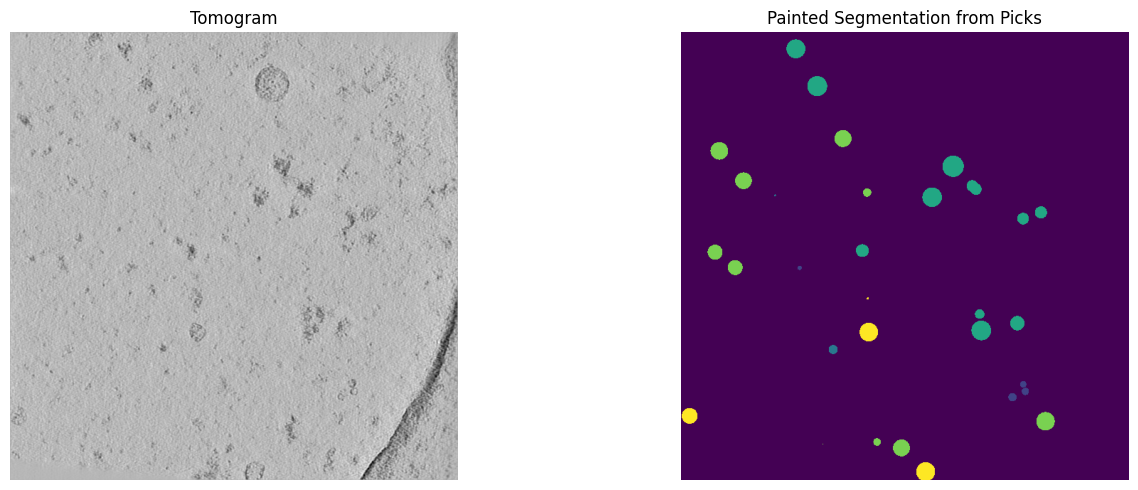

In [18]:
# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][100],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][100], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

## 5. Prepare dataloaders

In [19]:
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose,
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd,
    NormalizeIntensityd,
    RandCropByLabelClassesd,
    RandGaussianNoised,
    RandAdjustContrastd,
    MapTransform,
)
from monai.networks.nets import UNet, SwinUNETR
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric
import torchio as tio

In [20]:
exp_names_list = []
for i in range(len(data_dicts)):
    exp_name = data_dicts[i]['label_df']['experiment'][0]
    exp_names_list.append(exp_name)
exp_names_sr = pd.Series(exp_names_list)
unique_exp_names = exp_names_sr.unique()
unique_exp_names

array(['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3',
       'TS_99_9'], dtype=object)

In [21]:
len(unique_exp_names)

7

In [22]:
data_dicts_copy = copy.deepcopy(data_dicts)
len(data_dicts_copy)

7

In [23]:
# Define TorchIO transforms (applies to both image & label)
torchio_transforms = tio.Compose([
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, isotropic=True),  # Rotate & Scale
    tio.RandomElasticDeformation(num_control_points=7, max_displacement=5),  # Elastic deformation
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),  # Flip along axes
    tio.RandomNoise(std=0.1, include=["image"]),  # Noise ONLY on the image
    tio.RandomGhosting(num_ghosts=2, axes=(0, 1), include=["image"]),  # Ghosting ONLY on the image
])

In [24]:
class TorchIOTransform(MapTransform):
    """
    Applies TorchIO augmentations to both image and label.
    Ensures that both undergo the same transformations for segmentation tasks.
    """
    def __init__(self, keys, torchio_transform):
        super().__init__(keys)
        self.torchio_transform = torchio_transform

    def __call__(self, data):
        # Ensure the image tensor is 4D (C, H, W, D)
        image = data["image"]
        label = data["label"]

        if image.ndim == 5:  # (B, C, H, W, D) -> Remove batch dimension
            image = image.squeeze(0)
            label = label.squeeze(0)

        # Wrap image & label as a TorchIO Subject (keeps transformations consistent)
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),  # Ensure 4D (C, H, W, D)
            label=tio.LabelMap(tensor=label)  # Ensure 4D (C, H, W, D)
        )

        # Apply TorchIO transformations
        transformed = self.torchio_transform(subject)

        # Convert back to MONAI format
        data["image"] = transformed.image.data  # Keep it 4D
        data["label"] = transformed.label.data  # Keep it 4D
        return data

In [25]:
num_classes = 6 # 5 particles + 1 background
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1

In [26]:
# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandAdjustContrastd(keys=["image", "label"], prob=0.3, gamma=(0.7, 1.3)),  # Random contrast change
    TorchIOTransform(keys=["image", "label"], torchio_transform=torchio_transforms),  # Apply TorchIO
])

In [27]:
# Validation transforms
val_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=num_classes,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
        allow_missing_keys=True
    ),
])

## Model setup

In [28]:
"""
Derived from:
https://github.com/cellcanvas/album-catalog/blob/main/solutions/copick/compare-picks/solution.py
"""

import numpy as np
import pandas as pd

from scipy.spatial import KDTree


class ParticipantVisibleError(Exception):
    pass


def compute_metrics(reference_points, reference_radius, candidate_points):
    num_reference_particles = len(reference_points)
    num_candidate_particles = len(candidate_points)

    if len(reference_points) == 0:
        return 0, num_candidate_particles, 0

    if len(candidate_points) == 0:
        return 0, 0, num_reference_particles

    ref_tree = KDTree(reference_points)
    candidate_tree = KDTree(candidate_points)
    raw_matches = candidate_tree.query_ball_tree(ref_tree, r=reference_radius)
    matches_within_threshold = []
    for match in raw_matches:
        matches_within_threshold.extend(match)
    # Prevent submitting multiple matches per particle.
    # This won't be be strictly correct in the (extremely rare) case where true particles
    # are very close to each other.
    matches_within_threshold = set(matches_within_threshold)
    tp = int(len(matches_within_threshold))
    fp = int(num_candidate_particles - tp)
    fn = int(num_reference_particles - tp)
    return tp, fp, fn


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        distance_multiplier: float,
        beta: int) -> float:
    '''
    F_beta
      - a true positive occurs when
         - (a) the predicted location is within a threshold of the particle radius, and
         - (b) the correct `particle_type` is specified
      - raw results (TP, FP, FN) are aggregated across all experiments for each particle type
      - f_beta is calculated for each particle type
      - individual f_beta scores are weighted by particle type for final score
    '''

    particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

    weights = {
        'apo-ferritin': 1,
        'beta-amylase': 0,
        'beta-galactosidase': 2,
        'ribosome': 1,
        'thyroglobulin': 2,
        'virus-like-particle': 1,
    }

    particle_radius = {k: v * distance_multiplier for k, v in particle_radius.items()}

    # Filter submission to only contain experiments found in the solution split
    split_experiments = set(solution['experiment'].unique())
    submission = submission.loc[submission['experiment'].isin(split_experiments)]

    # Only allow known particle types
    if not set(submission['particle_type'].unique()).issubset(set(weights.keys())):
        raise ParticipantVisibleError('Unrecognized `particle_type`.')

    assert solution.duplicated(subset=['experiment', 'x', 'y', 'z']).sum() == 0
    assert particle_radius.keys() == weights.keys()

    results = {}
    for particle_type in solution['particle_type'].unique():
        results[particle_type] = {
            'total_tp': 0,
            'total_fp': 0,
            'total_fn': 0,
        }

    for experiment in split_experiments:
        for particle_type in solution['particle_type'].unique():
            reference_radius = particle_radius[particle_type]
            select = (solution['experiment'] == experiment) & (solution['particle_type'] == particle_type)
            reference_points = solution.loc[select, ['x', 'y', 'z']].values

            select = (submission['experiment'] == experiment) & (submission['particle_type'] == particle_type)
            candidate_points = submission.loc[select, ['x', 'y', 'z']].values

            if len(reference_points) == 0:
                reference_points = np.array([])
                reference_radius = 1

            if len(candidate_points) == 0:
                candidate_points = np.array([])

            tp, fp, fn = compute_metrics(reference_points, reference_radius, candidate_points)

            results[particle_type]['total_tp'] += tp
            results[particle_type]['total_fp'] += fp
            results[particle_type]['total_fn'] += fn

    aggregate_fbeta = 0.0
    for particle_type, totals in results.items():
        tp = totals['total_tp']
        fp = totals['total_fp']
        fn = totals['total_fn']

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0.0
        aggregate_fbeta += fbeta * weights.get(particle_type, 1.0)

    if weights:
        aggregate_fbeta = aggregate_fbeta / sum(weights.values())
    else:
        aggregate_fbeta = aggregate_fbeta / len(results)
    return aggregate_fbeta

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [30]:
class FBetaLoss(nn.Module):
    def __init__(self, beta=4, eps=1e-6, class_weights=None, enzyme_classes=5):
        super().__init__()
        self.beta = beta
        self.eps = eps
        self.enzyme_classes = enzyme_classes
        
        self.class_weights = class_weights or {
            'apo-ferritin': 1,
            'beta-galactosidase': 2,
            'ribosome': 1,
            'thyroglobulin': 2,
            'virus-like-particle': 1,
        }
        self.weight_tensor = torch.tensor(
            [self.class_weights[k] for k in self.class_weights.keys()],
            dtype=torch.float32
        )

    def forward(self, y_pred, y_true):
        # Convert y_true to proper format
        y_true = y_true.squeeze(1).long()  # Remove channel dim & ensure integer type
        
        y_pred_probs = F.softmax(y_pred, dim=1)
        y_pred_enzymes = y_pred_probs[:, 1:self.enzyme_classes+1, ...]
        
        # One-hot encoding with proper type handling
        y_true_onehot = F.one_hot(y_true, num_classes=6).permute(0, 4, 1, 2, 3).float()
        y_true_enzymes = y_true_onehot[:, 1:self.enzyme_classes+1, ...]

        tp = (y_pred_enzymes * y_true_enzymes).sum(dim=(2, 3, 4))
        fp = (y_pred_enzymes * (1 - y_true_enzymes)).sum(dim=(2, 3, 4))
        fn = ((1 - y_pred_enzymes) * y_true_enzymes).sum(dim=(2, 3, 4))

        precision = tp / (tp + fp + self.eps)
        recall = tp / (tp + fn + self.eps)
        beta2 = self.beta ** 2
        f_beta = (1 + beta2) * (precision * recall) / (beta2 * precision + recall + self.eps)

        weight_tensor = self.weight_tensor.to(y_pred.device)
        weighted_f_beta = f_beta * weight_tensor
        aggregate_f_beta = weighted_f_beta.sum(dim=1) / weight_tensor.sum()
        
        return 1 - aggregate_f_beta.mean()

In [31]:
class ParticleTverskyCrossEntropyLoss(nn.Module):
    def __init__(self, alpha=16/17, beta=1/17, ce_weight=0.2, tversky_weight=0.5, smooth=1e-6):
        """
        Args:
            particle_weights (torch.Tensor): Weights for 5 particles + background [0.0, 1.0, 2.0, 1.0, 2.0, 1.0]
            alpha: Tversky FP weight (prioritizes recall for beta=4)
            beta: Tversky FN weight
        """
        super().__init__()
        self.ce_weight = ce_weight
        self.tversky_weight = tversky_weight
        self.smooth = smooth
        self.alpha = alpha
        self.beta = beta

        particle_weights = torch.tensor([
            0.0,  # Background (weight=0)
            1.0,  # apo-ferritin
            2.0,  # beta-galactosidase (higher weight)
            1.0,  # ribosome
            2.0,  # thyroglobulin (higher weight)
            1.0   # virus-like-particle
        ], device='cuda')
        
        # Cross-Entropy with particle weights (background weight=0)
        self.ce = nn.CrossEntropyLoss(weight=particle_weights)
        self.register_buffer('class_weights', particle_weights)  # [6] tensor

    def forward(self, inputs, targets):
        # Ensure targets have the correct shape and dtype
        ce_loss = self.ce(inputs, targets.squeeze(1).long())
    
        # Tversky Loss (3D-compatible)
        num_classes = inputs.shape[1]
        probs = F.softmax(inputs, dim=1)
        targets_onehot = F.one_hot(targets.squeeze(1).long(), num_classes).permute(0, 4, 1, 2, 3).float()  # BCDHW
    
        # Flatten spatial dimensions (3D)
        probs_flat = probs.view(probs.size(0), num_classes, -1)  # [B,6,D*H*W]
        targets_flat = targets_onehot.view(targets_onehot.size(0), num_classes, -1)
    
        # Calculate TP/FP/FN (broadcasted across classes)
        tp = (probs_flat * targets_flat).sum(dim=2)  # [B,6]
        fp = (probs_flat * (1 - targets_flat)).sum(dim=2)
        fn = ((1 - probs_flat) * targets_flat).sum(dim=2)
    
        # Tversky index per class
        tversky = (tp + self.smooth) / (tp + self.alpha*fp + self.beta*fn + self.smooth)  # [B,6]
        tversky_loss = 1 - tversky
    
        # Apply class weights
        weighted_tversky = tversky_loss * self.class_weights  # [B,6]
        tversky_loss = weighted_tversky.mean()
    
        # Combined loss
        return self.ce_weight * ce_loss + self.tversky_weight * tversky_loss

In [32]:
class CombinedLoss(nn.Module):
    def __init__(self, lambda_fbeta=0.3, lambda_tversky=0.5, lambda_ce=0.2):
        super(CombinedLoss, self).__init__()
        self.fbeta_loss = FBetaLoss()
        self.wtversky_ce_loss = ParticleTverskyCrossEntropyLoss(ce_weight=lambda_ce, tversky_weight=lambda_tversky)

        self.lambda_fbeta = lambda_fbeta

    def forward(self, predictions, targets):
        """Compute combined loss over multiple anchors."""

        fbeta = self.fbeta_loss(predictions, targets)
        wtversky_ce = self.wtversky_ce_loss(predictions, targets)

        if torch.isnan(fbeta) or torch.isinf(fbeta):
            print(f"❌ NaN/Inf detected in fbeta loss function! fbeta Loss: {fbeta}")

        if torch.isnan(wtversky_ce) or torch.isinf(wtversky_ce):
            print(f"❌ NaN/Inf detected in wtversky_ce loss function! wtversky_ce Loss: {fbeta}")

        total_loss = fbeta * self.lambda_fbeta + wtversky_ce

        return total_loss

In [33]:
combined_loss_function = CombinedLoss()

In [34]:
class LF_beta_q_Loss(nn.Module):
    def __init__(self, beta=1.0, q=1.0, p=0.5):
        """
        Implements L_{Fβ,q} loss, which interpolates between F-beta loss and MAE loss.

        Args:
        - beta (float): Controls precision-recall balance (higher beta = more recall focus).
        - q (float): Controls robustness to label noise (0 < q ≤ 1).
        - p (float): Class balancing probability term (default: 0.5 for balanced classes).
        """
        super(LF_beta_q_Loss, self).__init__()
        self.beta = beta
        self.q = q
        self.p = p
        self.eps = 1e-7  # Small epsilon to prevent division by zero

    def forward(self, y_pred, y_true):
        """
        Compute the L_{Fβ,q} loss.

        Args:
        - y_pred: Model predictions (Sigmoid outputs, range 0-1) (B, C, D, H, W)
        - y_true: Ground truth binary masks (B, C, D, H, W)

        Returns:
        - Loss value (scalar)
        """
        # Ensure predictions are between a safe range
        y_pred = torch.clamp(y_pred, self.eps, 1 - self.eps)

        # First term: y * (1 - f(x;θ))^q / q
        term1 = y_true * ((1 - y_pred) / self.q).pow(self.q)

        # Second term: (1 - y) * (β^2 * p / (1 - p + f(x;θ)))^q
        term2 = (1 - y_true) * ((self.beta ** 2 * self.p) / (1 - self.p + y_pred)).pow(self.q)

        # Compute full loss (subtracting 1 ensures proper minimization)
        loss = term1 + term2 - 1

        return loss.mean()  # Return averaged loss over the batch

In [35]:
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
tversky_loss_function = TverskyLoss(include_background=False, to_onehot_y=True, softmax=True, alpha=16/17, beta=1/17)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

In [36]:
post_pred = AsDiscrete(argmax=True, to_onehot=num_classes)
post_label = AsDiscrete(to_onehot=num_classes)

In [37]:
from typing import List, Tuple, Union
import cc3d


def extract_3d_patches_minimal_overlap(arrays: List[np.ndarray], patch_size: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")
    
    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")
    
    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")
    
    m, n, l = shape
    patches = []
    coordinates = []
    
    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size)
    y_starts = calculate_patch_starts(n, patch_size)
    z_starts = calculate_patch_starts(l, patch_size)
    
    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))
    
    return patches, coordinates

    
def reconstruct_array(patches: List[np.ndarray], 
                     coordinates: List[Tuple[int, int, int]], 
                     original_shape: Tuple[int, int, int]) -> np.ndarray:
    reconstructed = np.zeros(original_shape, dtype=np.int64)  # To track overlapping regions
    
    patch_size = patches[0].shape[0]
    
    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] = patch
        
    
    return reconstructed

    
def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    if dimension_size <= patch_size:
        return [0]
        
    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)
    
    if n_patches == 1:
        return [0]
    
    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)
    
    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)
    
    return positions
    

def dict_to_df(coord_dict, experiment_name):
    # Create lists to store data
    all_coords = []
    all_labels = []
    
    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)
    
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })

    return df

In [38]:
id_to_name = {1: "apo-ferritin", 
              #2: "beta-amylase",
              2: "beta-galactosidase", 
              3: "ribosome", 
              4: "thyroglobulin", 
              5: "virus-like-particle"}

In [39]:
classes = [1, 2, 3, 4, 5]

In [40]:
def ensemble_prediction_tta(model, input_tensor, threshold=0.05):
    probs_list = []
    
    data_copy0 = input_tensor.clone()
    data_copy0 = torch.flip(data_copy0, dims=[2])
    data_copy1 = input_tensor.clone()
    data_copy1 = torch.flip(data_copy1, dims=[3])
    data_copy2 = input_tensor.clone()
    data_copy2 = torch.flip(data_copy2, dims=[4])
    data_copy3 = input_tensor.clone()
    data_copy3 = data_copy3.rot90(1, dims=[3, 4])
    
    model_output0 = model(input_tensor)
    model_output1 = model(data_copy0)
    model_output1 = torch.flip(model_output1, dims=[2])
    model_output2 = model(data_copy1)
    model_output2 = torch.flip(model_output2, dims=[3])
    model_output3 = model(data_copy2)
    model_output3 = torch.flip(model_output3, dims=[4])
    
    probs0 = torch.softmax(model_output0[0], dim=0)
    probs1 = torch.softmax(model_output1[0], dim=0)
    probs2 = torch.softmax(model_output2[0], dim=0)
    probs3 = torch.softmax(model_output3[0], dim=0)
    
    probs_list.append(probs0)
    probs_list.append(probs1)
    probs_list.append(probs2)
    probs_list.append(probs3)
    
    avg_probs = torch.mean(torch.stack(probs_list), dim=0)
    thresh_probs = avg_probs > threshold
    _, max_classes = thresh_probs.max(dim=0)
    
    return max_classes

In [41]:
from monai.transforms import (
    Compose, EnsureChannelFirstd, Orientationd, 
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, 
    CropForegroundd, ResizeWithPadOrCropd, Spacingd, ScaleIntensityRangeD
)

gpt_inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),  # Ensures channel-first format
    Orientationd(keys=["image"], axcodes="RAS"),  # Standardize orientation
    ScaleIntensityRangePercentilesd(keys=["image"], lower=1, upper=99, b_min=0.0, b_max=1.0, clip=True),  # Intensity normalization
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),  # Z-normalization
    ResizeWithPadOrCropd(keys=["image"], spatial_size=(96, 96, 96)),  # Crop or pad to fixed size
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),  # Resample to isotropic spacing
    ScaleIntensityRangeD(keys=["image"], a_min=0.0, a_max=1.0, b_min=0.0, b_max=1.0, clip=True)  # Clamp intensity values to [0,1]
])

In [42]:
inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS")
])

In [43]:
inference_transforms_dict = {
    'gpt': gpt_inference_transforms,
    'original': inference_transforms
}

In [44]:
loss_function_dict = {
    'combined': combined_loss_function,
    'tversky': tversky_loss_function
}

In [45]:
def kernel_size_convert(x):
    return x * 2 + 1

In [46]:
def objective(trial: optuna.Trial) -> float:
    learning_rate = trial.suggest_float('learning_rate', 3e-4, 3e-3)
    #third_channel = trial.suggest_int('third_channel', 64, 128)
    #fourth_channel = trial.suggest_int('fourth_channel', 64, 128)
    #first_stride = trial.suggest_int('first_stride', 1, 2)
    #second_stride = trial.suggest_int('second_stride', 1, 2)
    #third_stride = trial.suggest_int('third_stride', 1, 2)
    #num_res_units = trial.suggest_int('num_res_units', 2, 5)
    #loss_function_name = trial.suggest_categorical('loss_function', ['combined', 'tversky'])
    #loss_function = loss_function_dict[loss_function_name]
    prediction_threshold = trial.suggest_float('prediction_threshold', 0.01, 0.5)
    validation_experiment = trial.suggest_categorical('validation_experiment', ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9'])
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    #kernel_size = trial.suggest_int('kernel_size', 1, 4)
    #up_kernel_size = trial.suggest_int('up_kernel_size', 1, 4)
    #inference_name = trial.suggest_categorical('inference_transforms', ['gpt', 'original'])
    #inference = inference_transforms_dict[inference_name]
    #bias = trial.suggest_categorical('bias', [True, False])

    global data_dicts, data_dicts_copy

    data_dicts = copy.deepcopy(data_dicts_copy)

    train_files = []
    val_files = []
    
    for iii, v in enumerate(unique_exp_names == validation_experiment):
        if v == True:
            val_files.append(data_dicts[iii])
        else:
            train_files.append(data_dicts[iii])

    train_files_copy = copy.deepcopy(train_files)
    val_files_copy = copy.deepcopy(val_files)

    for iiii in range(len(train_files)):
        del train_files[iiii]['tomo_type'], train_files[iiii]['label_df']
    
    for iiiii in range(len(val_files)):
        del val_files[iiiii]['tomo_type'], val_files[iiiii]['label_df']

    # Create the cached dataset with non-random transforms
    train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0, progress=False)
    
    # Wrap the cached dataset to apply random transforms during iteration
    train_ds = Dataset(data=train_ds, transform=random_transforms)

    subjects = []
    for data in train_ds:  # data is a list of length 16
        for sample in data:  # sample is a dictionary
            image_tensor = sample['image']  # Extract image tensor
            label_tensor = sample['label'] # if 'label' in sample else None  # Extract label if available
            
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image_tensor),
                label=tio.LabelMap(tensor=label_tensor)# if label_tensor is not None else None
            )
            subjects.append(subject)

    # Convert to TorchIO Dataset
    train_ds_tio = tio.SubjectsDataset(subjects)
    
    # Use TorchIO SubjectsLoader instead of PyTorch DataLoader
    train_loader = tio.SubjectsLoader(
        train_ds_tio,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=torch.cuda.is_available()
    )
    
    # Create validation dataset
    val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0, progress=False)
    
    # Wrap the cached dataset to apply random transforms during iteration
    val_ds = Dataset(data=val_ds, transform=val_transforms)
    
    # Create validation DataLoader
    val_loader = DataLoader(
        val_ds,
        batch_size=val_batch_size,
        num_workers=8,
        pin_memory=torch.cuda.is_available(),
        shuffle=False,  # Ensure the data order remains consistent
    )

    # Create UNet, DiceLoss and Adam optimizer
    model = SwinUNETR(
        img_size=(96, 96, 96),
        in_channels=1,
        out_channels=num_classes,
        #feature_size=48,
        drop_rate=dropout,
        #use_v2=True
    ).to('cuda')
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    model = torch.compile(model, mode="default", dynamic=True)

    torch.set_float32_matmul_precision('high')
    
    #scaler = torch.amp.GradScaler('cuda')
    autocast_dtype = torch.bfloat16

    best_val_score = 0

    max_epochs = 1000

    writer = SummaryWriter("runs/experiment1")

    early_stopping_count = 0
    early_stopping_rounds = 10
    
    for epoch in range(max_epochs):        
        print("-" * 10)
        #print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        #step = 0
        for batch_data in train_loader:
            #step += 1
            inputs = batch_data["image"]['data'].to(device, non_blocking=True)
            labels = batch_data["label"]['data'].to(device, non_blocking=True)
    
            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda', dtype=autocast_dtype):
                outputs = model(inputs).to(device, non_blocking=True)
                loss = tversky_loss_function(outputs, labels)

            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        train_loss = epoch_loss / len(train_loader)
        #epoch_loss /= step

        #writer.add_scalar("Loss/Train", train_loss, epoch)
        
        #print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        running_val_loss = 0.0
        
        model.eval()
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda', dtype=autocast_dtype):
                for batch_data in val_loader:
                    inputs = batch_data['image'].to(device, non_blocking=True)
                    labels = batch_data['label'].to(device, non_blocking=True)
        
                    outputs = model(inputs)
                    loss = tversky_loss_function(outputs, labels)
        
                    running_val_loss += loss.item()
                
                solution_dfs_list = []
                submission_dfs_list = []
                exp_names_list = []
    
                for first_i in range(len(val_files_copy)):
                    val_data = val_files_copy[first_i]
    
                    exp_name = val_data['label_df']['experiment'][0]
                    if exp_name in exp_names_list:
                        continue
                    else:
                        exp_names_list.append(exp_name)
        
                    tomo = val_data['image']
                    tomo_patches, coordinates = extract_3d_patches_minimal_overlap([tomo], 96)
                    tomo_patched_data = [{"image": img} for img in tomo_patches]
                    tomo_ds = CacheDataset(data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0, progress=False, num_workers=8)
                    pred_masks = []
                    for second_i in range(len(tomo_ds)):
                        input_tensor = tomo_ds[second_i]['image'].unsqueeze(0).to("cuda", non_blocking=True)
                        max_classes = ensemble_prediction_tta(model, input_tensor, threshold=prediction_threshold)
                        pred_masks.append(max_classes.cpu().numpy())
        
                    reconstructed_mask = reconstruct_array(pred_masks, coordinates, tomo.shape)
                    location = {}
                    for c in classes:
                        cc = cc3d.connected_components(reconstructed_mask == c)
                        stats = cc3d.statistics(cc)
                        zyx = stats['centroids'][1:]
                        zyx_large = zyx[stats['voxel_counts'][1:] > 255]
                        xyz = np.ascontiguousarray(zyx_large[:, ::-1])
                        location[id_to_name[c]] = xyz
                    df = dict_to_df(location, val_data['label_df']['experiment'][0])
        
                    solution_df = val_data['label_df']
    
                    solution_dfs_list.append(solution_df)
                    submission_dfs_list.append(df)
    
                solution_concat_df = pd.concat(solution_dfs_list, ignore_index=True).reset_index(drop=True).reset_index().rename(columns={'index':'id'})[['id', 'experiment', 'particle_type', 'x', 'y', 'z']]
                submission_concat_df = pd.concat(submission_dfs_list, ignore_index=True).reset_index(drop=True).reset_index().rename(columns={'index':'id'})
        
                val_fbeta_score = score(solution_concat_df, submission_concat_df, 'id', 0.1*0.5, 4)
    
                if val_fbeta_score > best_val_score:
                    best_val_score = val_fbeta_score
                    early_stopping_count = 0

        early_stopping_count += 1

        val_loss = running_val_loss / len(val_loader)
        writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F beta score: {val_fbeta_score:.4f}, Best Val F beta score: {best_val_score:.4f}")

        if early_stopping_count >= early_stopping_rounds:
            print('Early Stopping Triggered.')
            break

    return best_val_score

In [ ]:
notebook_number = '20250201_01'
optuna_n_trials = 100

with tqdm(total=optuna_n_trials, desc="Optimizing", unit="trial") as pbar:
    
    # Define a callback function to update the progress bar
    def progress_bar_callback(study, trial):
        pbar.update(1)

    study = optuna.create_study(
        direction="maximize",
        sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler(),
        storage="sqlite:////home/max1024/Python Notebooks/czii/optuna_study/db.sqlite3",
        study_name=f"czii_SwinUNETR_param_tune_{notebook_number}"
    )
    study.optimize(objective, n_trials=optuna_n_trials, callbacks=[progress_bar_callback])

[I 2025-02-01 03:20:29,531] A new study created in RDB with name: czii_SwinUNETR_param_tune_20250201_01
monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


----------


[W 2025-02-01 03:24:58,633] Trial 0 failed with parameters: {'learning_rate': 0.0009572893769683258, 'prediction_threshold': 0.2783477415743008, 'validation_experiment': 'TS_99_9', 'dropout': 0.3901244230427221} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/max1024/venvs/ml/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_668663/2274133995.py", line 129, in objective
    outputs = model(inputs).to(device, non_blocking=True)
              ^^^^^^^^^^^^^
  File "/home/max1024/venvs/ml/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/max1024/venvs/ml/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)


In [ ]:
for param in study.best_params.keys():
    fig = plot_slice(study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(study)

In [ ]:
study.best_params

In [ ]:
study.best_value

# References

1. https://www.kaggle.com/code/hideyukizushi/czii-yolo11-unet3d-monai-lb-707